In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gzip
import shutil
import os
import time

%matplotlib inline

In [32]:
np.random.seed(0)

In [33]:
# data amplitudes
D1AMP, D2AMP, D3AMP, D4AMP = 10.0, 1.0, 0.5, 0.1
# data update frequencies / pi
D1FRQ, D2FRQ, D3FRQ, D4FRQ = 1.0, 0.1, 3.0, 10.0
DTYPE = np.float32
# noise amplitudes
N1AMP, N2AMP, N3AMP, N4AMP = 0.05, 0.04, 0.02, 0.01

In [34]:
default_commands = np.array([-0.5, -0.375, -0.25, -0.125, 0.0,
                                 0.125, 0.25, 0.375, 0.5], dtype=DTYPE)
DEFAULT_COMMANDS = default_commands

In [35]:
class MachineStateTextRecorder(object):
    '''
    record time, machine setting, sensor values, true values
    '''

    def __init__(self, log_base_name):
        self.log_name = log_base_name + '.csv'
        self.gzfile = self.log_name + '.gz'
        self.cleanup_files()

    def cleanup_files(self):
        for f in [self.log_name, self.gzfile]:
            if os.path.isfile(f):
                os.remove(f)

    def write_data(self, t, setting, measurements, targets):
        '''measurements are measured sensors, targets are true values'''
        try:
            with open(self.log_name, 'ab+') as f:
                meas_string = ','.join([str(i) for i in measurements])
                targ_string = ','.join([str(i) for i in targets])
                msg = str(t) + ',' + str(setting) + ',' + meas_string + \
                    ',' + targ_string + '\n'
                f.write(bytes(msg, 'utf8'))
            return True
        except Exception as e:
            raise e
        return False

    def read_data(self):
        '''
        do not call this on large files
        NOTE: we are assuming gzip compression has occurred!
        '''
        with gzip.open(self.log_name + '.gz', 'rb') as f:
            content = f.readlines()
            content = [x.decode('utf8').strip() for x in content]
        return content

    def close(self):
        with open(self.log_name, 'rb') as f_in:
            with gzip.open(self.gzfile, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        if os.path.isfile(self.gzfile) and (os.stat(self.gzfile).st_size > 0):
            os.remove(self.log_name)
        else:
            raise IOError('Compressed file not produced!')

In [36]:
class DataGenerator(object):
    amp = np.asarray([D1AMP, D2AMP, D3AMP, D4AMP], dtype=DTYPE)
    frq = np.pi * np.asarray([D1FRQ, D2FRQ, D3FRQ, D4FRQ], dtype=DTYPE)

    def __init__(self, time_step=0.01):
        self.t = 0
        self.time_step = time_step
        assert len(DataGenerator.amp) == len(DataGenerator.frq)

    def _gen_point(self):
        raw_vs = []
        for i in range(len(DataGenerator.amp)):
            raw_vs.append(
                DataGenerator.amp[i] * np.cos(DataGenerator.frq[i] * self.t)
            )
        return np.asarray(raw_vs, dtype=DTYPE)

    def step(self):
        self.t = self.t + self.time_step
        data = self._gen_point()
        return data

In [37]:
class NoiseModel(object):
    default_noise_scale = [N1AMP, N2AMP, N3AMP, N4AMP]

    def __init__(self, drop_probability=0.0, noise_array=None):
        self.noise = noise_array or np.asarray(
            NoiseModel.default_noise_scale, dtype=DTYPE
        )
        assert len(self.noise) == 4

    def gen_noise(self, data):
        assert len(data) == 4
        noise_values = []
        for i, d in enumerate(data):
            noise_values.append(
                self.noise[i] * data[i] * np.random.randn()
            )
        return np.asarray(noise_values, dtype=DTYPE)

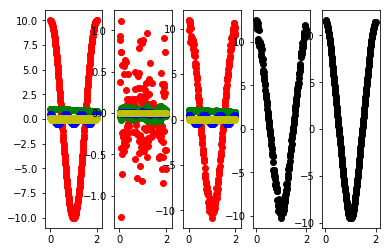

In [38]:
dgen = DataGenerator()
nosgen = NoiseModel()
d1 = []
d2 = []
d3 = []
d4 = []
n1 = []
n2 = []
n3 = []
n4 = []
m1 = []
m2 = []
m3 = []
m4 = []
trues = []
totals = []
ts = []
for i in range(200):
    data = dgen.step()
    noise = nosgen.gen_noise(data)
    measured = data + noise
    ts.append(dgen.t)
    for i, a in enumerate([d1, d2, d3, d4]):
        a.append(data[i])
    trues.append(sum(data))
    for i, n in enumerate([n1, n2, n3, n4]):
        n.append(noise[i])
    for i, m in enumerate([m1, m2, m3, m4]):
        m.append(measured[i])
    totals.append(sum(measured))

fig = plt.Figure(figsize=(8, 6))
gs = plt.GridSpec(1, 5)
ax1 = plt.subplot(gs[0])
ax1.scatter(ts, d1, c='r')
ax1.scatter(ts, d2, c='g')
ax1.scatter(ts, d3, c='b')
ax1.scatter(ts, d4, c='y')
ax2 = plt.subplot(gs[1])
ax2.scatter(ts, n1, c='r')
ax2.scatter(ts, n2, c='g')
ax2.scatter(ts, n3, c='b')
ax2.scatter(ts, n4, c='y')
ax3 = plt.subplot(gs[2])
ax3.scatter(ts, m1, c='r')
ax3.scatter(ts, m2, c='g')
ax3.scatter(ts, m3, c='b')
ax3.scatter(ts, m4, c='y')
ax4 = plt.subplot(gs[3])
ax4.scatter(ts, totals, c='k')
ax5 = plt.subplot(gs[4])
ax5.scatter(ts, trues, c='k')
plt.show()

(array([ 1.,  6., 12., 29., 52., 60., 26., 11.,  1.,  1.]),
 array([-2.06094952, -1.63972046, -1.21849139, -0.79726233, -0.37603327,
         0.0451958 ,  0.46642486,  0.88765392,  1.30888299,  1.73011205,
         2.15134112]),
 <a list of 10 Patch objects>)

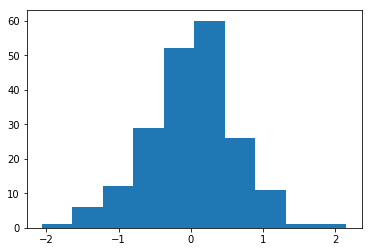

In [39]:
t0s = np.asarray(totals[0:-1])
t1s = np.asarray(totals[1:])
tdiff = t1s - t0s
tdiff[:10]
plt.hist(tdiff)

(array([45., 26., 13.,  7.,  8.,  9.,  7., 13., 26., 45.]),
 array([-0.30409346, -0.24346772, -0.18284199, -0.12221626, -0.06159053,
        -0.0009648 ,  0.05966093,  0.12028667,  0.1809124 ,  0.24153813,
         0.30216386]),
 <a list of 10 Patch objects>)

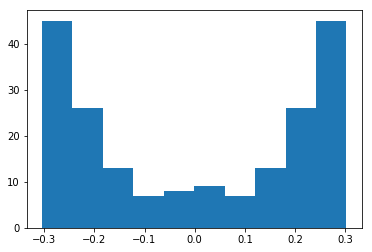

In [40]:
t0s = np.asarray(trues[0:-1])
t1s = np.asarray(trues[1:])
tdiff = t1s - t0s
tdiff[:10]
plt.hist(tdiff)

In [41]:
class SimulationMachine(object):
    '''
    intended operation:
    1. update the machine setting
    2. step the machine
        a. step the data generator (generate data and advance the time)
        b. add noise
        c. update sensor values
        d. if logging, record machine state
    3. report the "heat" (difference between machine setting and true state)
    '''
    # default_commands = np.linspace(-0.5, 0.5, num=9, dtype=DTYPE)
    default_commands = np.array([-0.5, -0.375, -0.25, -0.125, 0.0,
                                 0.125, 0.25, 0.375, 0.5], dtype=DTYPE)

    def __init__(
        self, setting, data_generator, noise_model, logger=None, commands=None
    ):
        self._data_generator = data_generator
        self._noise_model = noise_model
        self._setting = setting
        self._heat = 0.0
        self._true_state = 0.0
        self._commands = commands or SimulationMachine.default_commands
        self._sensors = np.zeros(4, dtype=DTYPE)
        self._logger = logger

    def update_machine(self, command):
        '''command is the index of the step change'''
        self._setting = self._setting + self._commands[command]

    def step(self):
        data = self._data_generator.step()
        self._true_state = np.sum(data)
        noise = self._noise_model.gen_noise(data)
        measured = data + noise
        self._sensors = measured
        if self._logger is not None:
            self._logger.write_data(self._data_generator.t, self._setting,
                                    measured, data)

    def get_heat(self):
        return (self._true_state - self._setting) ** 2

    def get_time(self):
        return self._data_generator.t

    def get_setting(self):
        return self._setting

    def get_commands(self):
        return list(self._commands)

    def get_sensor_values(self):
        return list(self._sensors)

In [42]:
class SimpleRuleBased(object):
    '''
    intended operation:
    1. observe the machine state
    2. compute a new setting value and apply it
    '''

    def __init__(
        self, time, setting, amplitude, period, commands_array
    ):
        '''
        amplitude = max value, period = max -> min -> max t
        '''
        self._time = time
        self._setting = setting
        self._amplitude = amplitude
        self._period = period
        self._state = None
        self._commands = np.asarray(commands_array, dtype=DTYPE)

    def set_state(self, sensor_array):
        '''
        sensor_array should be a 5 element array - one for each sensor, t.
        this policy ignores state and only uses t

        TODO - this should take a minibatch, not a single point
        '''
        self._state = sensor_array[0:4]
        self._time = sensor_array[-1]

    def compute_action(self):
        '''
        pure time-based, want to go from ampl to -ampl as t goes from
        0->1, then from -ampl to ampl as t goes from 1->2
        '''
        t = self._time % 2
        if t < (self._period / 2.0):
            slope = -2.0 * self._amplitude
            intercept = self._amplitude
        if t >= (self._period / 2.0):
            slope = 2.0 * self._amplitude
            intercept = -3.0 * self._amplitude
        target = slope * t + intercept
        delta = target - self._setting
        diffs = np.abs(self._commands - delta)
        command = np.argmin(diffs)
        return command

    def update_setting(self, command):
        '''command is the index of the step change'''
        self._setting = self._setting + self._commands[command]

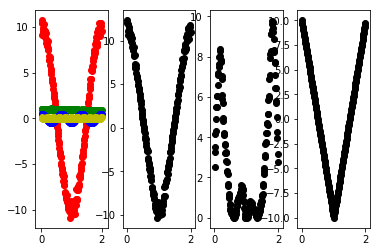

In [43]:
dgen = DataGenerator()
nosgen = NoiseModel()
machine = SimulationMachine(setting=10.0, data_generator=dgen,
                           noise_model=nosgen)
policy = SimpleRuleBased(time=0.0, setting=10.0, amplitude=10.0,
                        period=2.0, commands_array=machine.get_commands())

m1 = []
m2 = []
m3 = []
m4 = []
totals = []
heat = []
settings = []
ts = []
for i in range(200):
    machine.step()
    t = machine.get_time()
    sensor_vals = machine.get_sensor_values()
    ts.append(t)
    for i, m in enumerate([m1, m2, m3, m4]):
        m.append(sensor_vals[i])
    totals.append(sum(sensor_vals))
    settings.append(machine.get_setting())
    heat.append(machine.get_heat())
    state = sensor_vals + [t]
    policy.set_state(state)
    command = policy.compute_action()
    machine.update_machine(command)
    policy.update_setting(command)

fig = plt.Figure(figsize=(8, 6))
gs = plt.GridSpec(1, 4)
ax1 = plt.subplot(gs[0])
ax1.scatter(ts, m1, c='r')
ax1.scatter(ts, m2, c='g')
ax1.scatter(ts, m3, c='b')
ax1.scatter(ts, m4, c='y')
ax2 = plt.subplot(gs[1])
ax2.scatter(ts, totals, c='k')
ax3 = plt.subplot(gs[2])
ax3.scatter(ts, heat, c='k')
ax4 = plt.subplot(gs[3])
ax4.scatter(ts, settings, c='k')

plt.show()

In [45]:
'train'.upper()

'TRAIN'